In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.optim.lr_scheduler import ReduceLROnPlateau

from get_loader_v2_train_val_test import get_train_loader, get_val_test_loader, get_length_vocab, get_pad_index, get_vocab, show_image


from train_and_val import train, validate, val_visualize_captions

from models.models import  EncoderDecoder

import pandas as pd
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import wandb


In [2]:
data_dir = 'data/Images/'
captions_file = 'data/captions.txt'

input_size = (224,224)

transform_train = transforms.Compose(
[
transforms.Resize(input_size),   
transforms.RandomHorizontalFlip(),          # ADDED RANDOM HORIZONTAL FLIP
transforms.ToTensor(),
])

transform_val = transforms.Compose(
[
transforms.Resize(input_size),
transforms.ToTensor(),
])

# Split data into train and test sets
df_captions = pd.read_csv(captions_file)
unique_images = df_captions['image'].unique()
train_images, test_images = train_test_split(unique_images, test_size=0.2, random_state=42)
train_images, val_images = train_test_split(train_images, test_size=0.2, random_state=42)

train_df = df_captions[df_captions['image'].isin(train_images)]
val_df = df_captions[df_captions['image'].isin(val_images)]
test_df = df_captions[df_captions['image'].isin(test_images)]

pad_index = get_pad_index(data_dir=data_dir, dataframe=train_df, transform=transform_train)

vocab_train_df = get_vocab(data_dir=data_dir, dataframe=train_df, transform=transform_train)
vocab_val_df = get_vocab(data_dir=data_dir, dataframe=val_df, transform=transform_val)
vocab_test_df = get_vocab(data_dir=data_dir, dataframe=test_df, transform=transform_val)


# Create train, validation, and test data loaders
train_dataloader = get_train_loader(data_dir=data_dir, dataframe=train_df, transform=transform_train, batch_size=8, num_workers=1, shuffle = True) # Batch size 8
val_dataloader = get_val_test_loader(data_dir=data_dir, dataframe=val_df, transform=transform_val, batch_size=4, num_workers=1, shuffle = False) # Batch size 4
test_dataloader = get_val_test_loader(data_dir=data_dir, dataframe=test_df, transform=transform_val, batch_size=16, num_workers=1)



In [3]:
# Hyperparameters
embed_size = 400
hidden_size = 512
vocab_size_train = len(vocab_train_df)
num_layers = 2
learning_rate = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:

# initialize model, loss etc
load_model = False
torch.backends.cudnn.benchmark = True

if load_model:
    model = EncoderDecoder(embed_size, hidden_size, vocab_size_train, num_layers).to(device)
    model.load_state_dict(torch.load('model_weights.py'))
    model.eval()
else:
    # initialize model, loss etc
    model = EncoderDecoder(embed_size, hidden_size, vocab_size_train, num_layers).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=pad_index)
    optimizer = optim.Adam(model.parameters(), lr=learning_rate) # We apply weight decay that is L2 reg to prevent overfitting
    #scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=3, verbose=True)

c:\Users\Miguel\anaconda3\envs\Pytorch_2\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Miguel\anaconda3\envs\Pytorch_2\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [6]:
'''
wandb.init(entity="imgcaption_dl_project", project="miguel-moral (imgcaption_dl_project)")
wandb.config.embed_size = embed_size
wandb.config.hidden_size = hidden_size
wandb.config.vocab_size_train = vocab_size_train
wandb.config.num_layers = num_layers
wandb.config.learning_rate = learning_rate
wandb.config.device = device
#wandb.config.scheduler = scheduler

wandb.watch(model)
wandb.log({"Model": wandb.Graph(model)})
wandb.log({"Optimizer": str(optimizer)})

'''

'\nwandb.init(entity="imgcaption_dl_project", project="miguel-moral (imgcaption_dl_project)")\nwandb.config.embed_size = embed_size\nwandb.config.hidden_size = hidden_size\nwandb.config.vocab_size_train = vocab_size_train\nwandb.config.num_layers = num_layers\nwandb.config.learning_rate = learning_rate\nwandb.config.device = device\n#wandb.config.scheduler = scheduler\n\nwandb.watch(model)\nwandb.log({"Model": wandb.Graph(model)})\nwandb.log({"Optimizer": str(optimizer)})\n\n'

Train Epoch: 0 Batch [1000/3236]	Loss: 3.29672
Train Epoch: 0 Batch [2000/3236]	Loss: 2.83671
Train Epoch: 0 Batch [3000/3236]	Loss: 2.78201
Train Epoch: 0 Average Loss: 3.11482
Validation set: Average loss: 6.94581


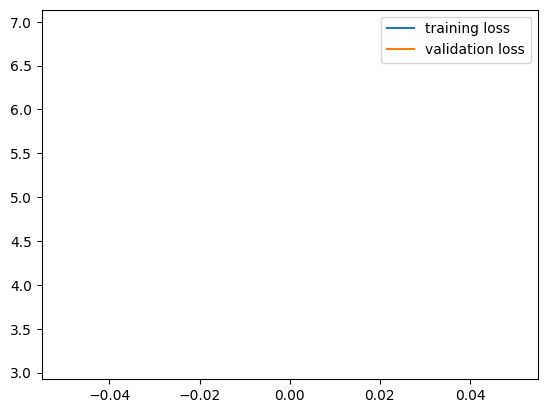

Train Epoch: 1 Batch [1000/3236]	Loss: 2.72391
Train Epoch: 1 Batch [2000/3236]	Loss: 2.74524
Train Epoch: 1 Batch [3000/3236]	Loss: 2.47063
Train Epoch: 1 Average Loss: 2.57346
Validation set: Average loss: 7.40072


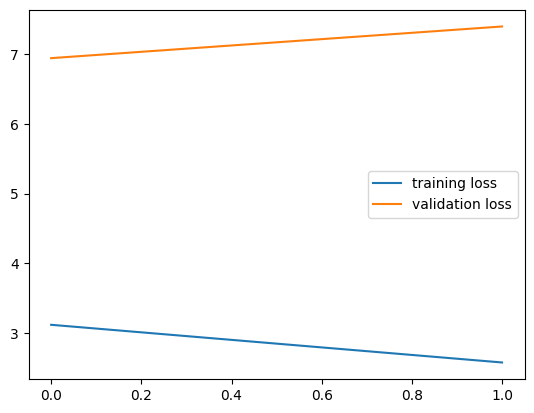

Train Epoch: 2 Batch [1000/3236]	Loss: 2.26691
Train Epoch: 2 Batch [2000/3236]	Loss: 2.37944
Train Epoch: 2 Batch [3000/3236]	Loss: 2.15924
Train Epoch: 2 Average Loss: 2.32514
Validation set: Average loss: 7.78394


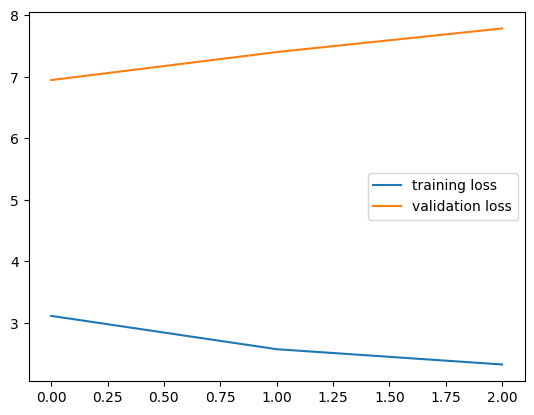

Train Epoch: 3 Batch [1000/3236]	Loss: 2.26839
Train Epoch: 3 Batch [2000/3236]	Loss: 2.28512
Train Epoch: 3 Batch [3000/3236]	Loss: 2.41324
Train Epoch: 3 Average Loss: 2.11946
Validation set: Average loss: 8.28808


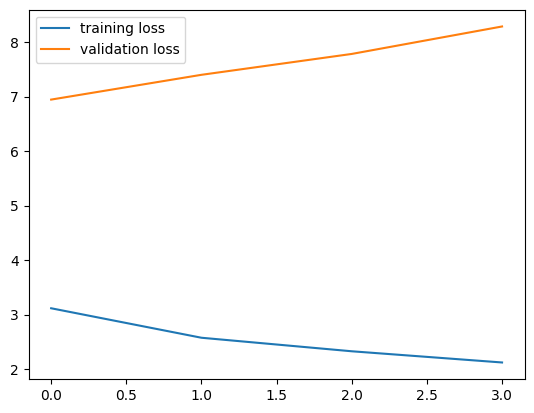

Train Epoch: 4 Batch [1000/3236]	Loss: 1.84762
Train Epoch: 4 Batch [2000/3236]	Loss: 2.03035
Train Epoch: 4 Batch [3000/3236]	Loss: 2.22454
Train Epoch: 4 Average Loss: 1.92610
Validation set: Average loss: 8.96772


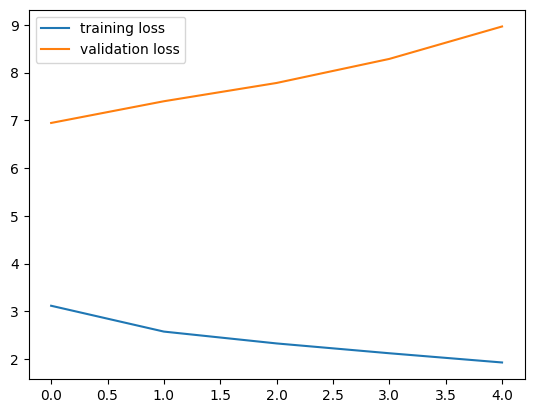

Train Epoch: 5 Batch [1000/3236]	Loss: 1.57355
Train Epoch: 5 Batch [2000/3236]	Loss: 1.65373
Train Epoch: 5 Batch [3000/3236]	Loss: 1.77869
Train Epoch: 5 Average Loss: 1.74999
Validation set: Average loss: 9.32310


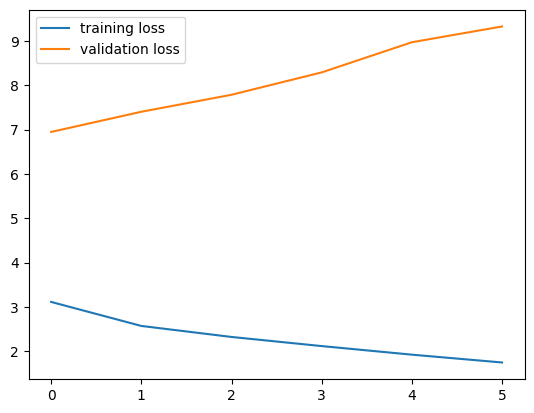

Train Epoch: 6 Batch [1000/3236]	Loss: 1.58641
Train Epoch: 6 Batch [2000/3236]	Loss: 1.65725


KeyboardInterrupt: 

In [7]:
### USING TRAIN AND VAL SEPARATED FUNCTIONS ONLY VISUALIZING LOSS VALUES FROM TRAINING AND VAL

losses = {"train": [], "val": []}
for epoch in range(20):

    train_loss = train(epoch, criterion, model, optimizer, train_dataloader, device)
    val_loss = validate(criterion, model, val_dataloader, device)
    losses["train"].append(train_loss)
    losses["val"].append(val_loss)
    #wandb.log({"train_loss": train_loss, "val_loss": val_loss})
    
    plt.plot(losses["train"], label="training loss")
    plt.plot(losses["val"], label="validation loss")

    plt.legend()
    plt.pause(0.000001)
    plt.show()
#wandb.save('model_checkpoint.pth')


In [ ]:
#wandb.finish()

train_loss,█▆▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁
val_loss,▁▂▂▂▃▃▃▄▄▄▅▅▅▆▆▇▇▇██
Optimizer,Adam ( Parameter Gro...
train_loss,0.03672
val_loss,0.69324


In [ ]:
torch.save(model.state_dict(), 'model_with_dropout.pt')

Epoch: 1 loss: 3.82861
['1015118661_980735411b.jpg', '1015118661_980735411b.jpg', '1015118661_980735411b.jpg', '1015118661_980735411b.jpg']
features shape - torch.Size([1, 400])
True captions of the image:
 ['A boy smiles in front of a stony wall in a city .', 'A little boy is standing on the street while a man in overalls is working on a stone wall .', 'A young boy runs aross the street .', 'A young child is walking on a stone paved street with a metal pole and a man behind him .', 'Smiling boy in white shirt and blue jeans in front of rock wall with man in overalls behind him .']
Predicted caption:
<SOS> a man is running in the water . <EOS>


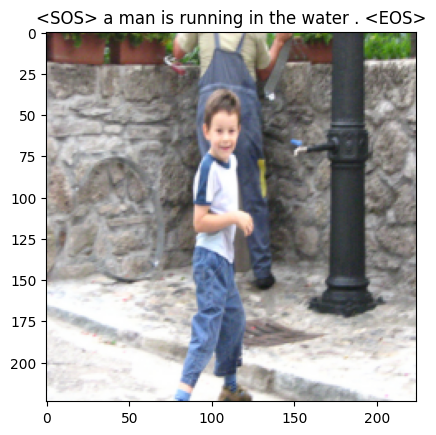

Epoch: 1 loss: 3.93296
['1015118661_980735411b.jpg', '1015118661_980735411b.jpg', '1015118661_980735411b.jpg', '1015118661_980735411b.jpg']
features shape - torch.Size([1, 400])
True captions of the image:
 ['A boy smiles in front of a stony wall in a city .', 'A little boy is standing on the street while a man in overalls is working on a stone wall .', 'A young boy runs aross the street .', 'A young child is walking on a stone paved street with a metal pole and a man behind him .', 'Smiling boy in white shirt and blue jeans in front of rock wall with man in overalls behind him .']
Predicted caption:
<SOS> a man in a red shirt is jumping on a field . <EOS>


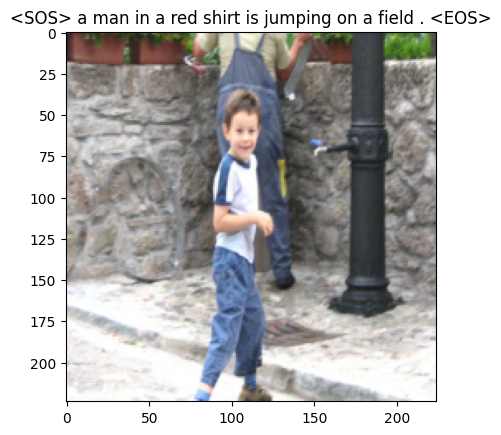

Epoch: 1 loss: 3.44903
['1015118661_980735411b.jpg', '1015118661_980735411b.jpg', '1015118661_980735411b.jpg', '1015118661_980735411b.jpg']
features shape - torch.Size([1, 400])
True captions of the image:
 ['A boy smiles in front of a stony wall in a city .', 'A little boy is standing on the street while a man in overalls is working on a stone wall .', 'A young boy runs aross the street .', 'A young child is walking on a stone paved street with a metal pole and a man behind him .', 'Smiling boy in white shirt and blue jeans in front of rock wall with man in overalls behind him .']
Predicted caption:
<SOS> a man in a blue shirt is running through the grass . <EOS>


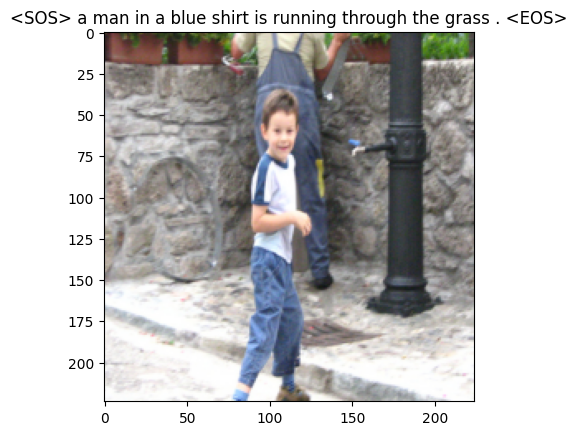

Epoch: 1 loss: 2.80389
['1015118661_980735411b.jpg', '1015118661_980735411b.jpg', '1015118661_980735411b.jpg', '1015118661_980735411b.jpg']
features shape - torch.Size([1, 400])
True captions of the image:
 ['A boy smiles in front of a stony wall in a city .', 'A little boy is standing on the street while a man in overalls is working on a stone wall .', 'A young boy runs aross the street .', 'A young child is walking on a stone paved street with a metal pole and a man behind him .', 'Smiling boy in white shirt and blue jeans in front of rock wall with man in overalls behind him .']
Predicted caption:
<SOS> a man in a red shirt and a black and white shirt is standing on a skateboard . <EOS>


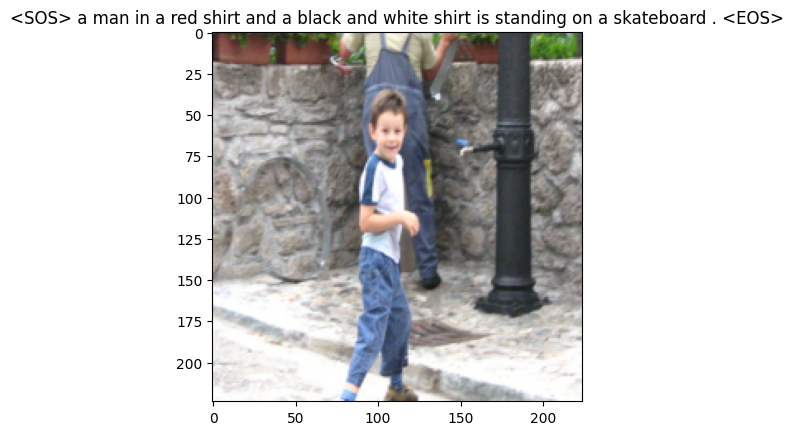

Epoch: 1 loss: 2.78385
['1015118661_980735411b.jpg', '1015118661_980735411b.jpg', '1015118661_980735411b.jpg', '1015118661_980735411b.jpg']
features shape - torch.Size([1, 400])
True captions of the image:
 ['A boy smiles in front of a stony wall in a city .', 'A little boy is standing on the street while a man in overalls is working on a stone wall .', 'A young boy runs aross the street .', 'A young child is walking on a stone paved street with a metal pole and a man behind him .', 'Smiling boy in white shirt and blue jeans in front of rock wall with man in overalls behind him .']
Predicted caption:
<SOS> a man in a blue shirt and a woman in a blue shirt and a blue shirt and a woman in a blue shirt


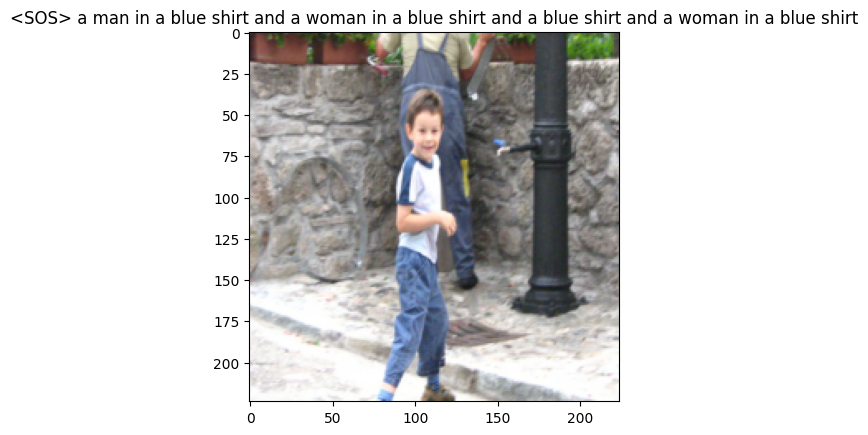

KeyboardInterrupt: 

In [5]:
### USING A FUNCTION TO VISUALIZE THE CAPTIONS GENERATED IN VAL FROM THE TRAINING (WE TRAIN AGAIN AND VISALIZE THE CAPTIONS IN VAL, IT TAKES LONGER IF YOU JUST WANT TO TRAIN
# WE TRAIN AGAIN AND VISALIZE THE CAPTIONS IN VAL, IT TAKES LONGER IF YOU JUST WANT TO TRAIN RUN THE CELL ABOVE
val_visualize_captions(model, train_dataloader, val_dataloader, criterion, optimizer, device, vocab_size_train, vocab_train_df, 20, val_df)

In [ ]:
### LET'S TEST, NO LO HE PROBADO CREO Q LO DEL ITOS NO IRIA PERO HAY UAN FUNCION Q TE DEVUELVE EL ITOS EN NUESTRO GETLOADER.
# THIS IS ONLY FOR 1 BATCH


# generate the captions for a whole batch
model.eval()
with torch.no_grad():
    
    itr = iter(test_dataloader)  # TEST LOADER
    img, captions, img_ids = next(itr)
    
    caption = captions[0:1][0].tolist()
    s = [vocab_test_df[idx] for idx in caption if idx != 0] # if idx != 0 and idx != 1 and idx != 2 (to erase eos and sos if we want idx 1 and 2)
    print("Original:", ' '.join(s))
    
    # extract features
    print(img[0:1].shape)
    features = model.encoder(img[0:1].to(device))

    # get predictions
    pred_caps, alphas = model.decoder.generate_caption(features, vocab=vocab_test_df)

    # make it printable
    caption = ' '.join(pred_caps)
    print("Predicted:", caption)
    show_image(img[0])